# Introducción: Proyecto de Machine Learning Parte 1

Al leer un libro de ciencia de datos o seguir un curso, puedes sentir que tienes piezas individuales, pero no sabes cómo unirlas. Dar el siguiente paso y resolver un problema de machine learning completo puede ser desalentador, pero enfrentarse y completar un primer proyecto le dará la confianza para afrontar cualquier problema relacionado con data science. Esta serie de notebooks analizará una solución completa de machine learning con un conjunto de datos del mundo real para que pueda ver cómo se unen todas las piezas.

Seguiremos paso a paso el flujo general de trabajo de machine learning:

1. Limpieza y formateo de datos.
2. Análisis exploratorio de datos
3. Ingeniería y selección de características.
4. Comparar varios modelos de machine learning en una métrica de rendimiento.
5. Ajuste del hiperparámetro en el mejor modelo
6. Evaluar el mejor modelo en el conjunto de pruebas
7. Interpretar los resultados del modelo.
8. Sacar conclusiones y documentar el trabajo.

En el camino veremos cómo cada paso fluye hacia el siguiente y cómo implementar específicamente cada parte en Python.

Definir esta estructura antes de tiempo nos permite ver cómo un paso fluye hacia el otro. Sin embargo, el proceso de machine learning es un procedimiento iterativo, por lo que no siempre seguimos estos pasos de manera lineal. Es posible que volvamos a revisar un paso anterior en función de los resultados de una etapa posterior. Por ejemplo, si bien podemos realizar una selección de características antes de construir cualquier modelo, podemos usar los resultados del modelado para retroceder y seleccionar un conjunto diferente de características. O el modelado puede generar resultados inesperados que signifiquen que queremos explorar nuestros datos desde otro ángulo.

A lo largo de esta serie de notebooks, el objetivo es mostrar cómo todas las diferentes prácticas de data science se unen para formar un proyecto completo. Trato de centrarme más en la implementación de los métodos en lugar de explicarlos en un nivel bajo, pero he proporcionado recursos para aquellos que desean profundizar. Uno de los mejores libros individuales para aprender lo básico e implementar prácticas de machine learning en Python es [Hands-On Machine Learning with Scikit-Learn and Tensorflow](http://shop.oreilly.com/product/0636920052289.do) de [Aurelion Geron](https://twitter.com/aureliengeron?lang=en).

## Definición del problema

El primer paso es comprender el problema que estamos tratando de resolver y los datos disponibles. En este proyecto, trabajaremos con [datos de energía de edificios disponibles públicamente de la ciudad de Nueva York](http://www.nyc.gov/html/gbee/html/plan/ll84_scores.shtml).

**El objetivo es utilizar los datos de energía para construir un modelo que pueda predecir la puntuación Energy Star de un edificio e interpretar los resultados para encontrar los factores que influyen en dicha puntuación**.

Los datos incluyen la puntuación Energy Star, por tanto, se trata de una tarea de machine learning de regresión supervisada:

+ **Supervisado**: tenemos acceso tanto a las características como al objetivo y nuestro objetivo es entrenar un modelo que pueda aprender un mapeo entre los dos.
+ **Regresión**: la puntuación de Energy Star es una variable continua (en este caso va de 0 a 100).

Queremos desarrollar un modelo que sea a la vez **preciso**: puede predecir el puntaje Energy Star cerca del valor real, e **interpretable**: podemos entender las predicciones del modelo. Una vez que conozcamos el objetivo, podemos usarlo para guiar nuestras decisiones a medida que profundizamos en los datos y construimos modelos. Durante el entrenamiento, queremos que el modelo aprenda la relación entre las características y la puntuación, por lo que le damos las características y la respuesta. Luego, para probar cómo de bien ha aprendido el modelo, ¡lo evaluamos en un conjunto de pruebas donde nunca ha visto las respuestas!

## Imports

Usaremos las bibliotecas estándar de ciencia de datos y machine learning: numpy, pandas y scikit-learn. También utilizamos matplotlib y seaborn para visualización.

In [24]:
# Pandas y numpy para manipulación de datos
import pandas as pd
import numpy as np

# Quitamos los warnings sobre el establecimiento de un valor en una copia de un slice
pd.options.mode.chained_assignment = None

# Mostramos hasta 60 columnas de un dataframe
pd.set_option('display.max_columns', 60)

# Visualización Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Establece el tamaño de fuente por defecto
plt.rcParams['font.size'] = 24

# Herramienta interna ipython para establecer el tamaño de la figura
from IPython.core.pylabtools import figsize

# Visualizción por Seaborn
import seaborn as sns
sns.set(font_scale = 2)

# División de los datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split

# Librería para mostrár imágenes
from IPython.display import Image

## Limpieza de datos

Contrariamente a lo que pueda parecer, no todos los conjuntos de datos son un grupo de observaciones perfectamente saneado, sin valores perdidos ni anomalías (como puede creerse observando los conjuntos de datos de [mtcars](http://stat.ethz.ch/R-manual/R-devel/library/datasets/html/mtcars.html) e [iris](https://archive.ics.uci.edu/ml/datasets/iris)). Los datos del mundo real son confusos, lo que significa que debemos [limpiarlos y cambiarlos](https://www.springboard.com/blog/data-wrangling/) a un formato aceptable antes de que podamos comenzar el análisis. La limpieza de datos es una parte poco glamurosa pero necesaria de la mayoría de los problemas reales de data science.

Cargaremos nuestros datos en un `dataframe` de pandas, una de las estructuras de datos más útiles de data science. Piense en ello como una hoja de cálculo dentro de Python que podemos manipular, limpiar y visualizar fácilmente. Pandas [tiene muchos métodos](http://pandas.pydata.org/pandas-docs/stable/) para ayudar a que el flujo de información de ciencia de datos / machine learning sea lo más sencillo posible.

In [2]:
# Cargamos los datos en un dataframe 
data = pd.read_csv("./data/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv")

# Display top of dataframe
data.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,10017,675,3 AVENUE,Manhattan,289356.0,Office,Office,Office,293447,Not Available,Not Available,Not Available,Not Available,1963,2,100,Whole Building,Not Available,Not Available,305.6,303.1,37.8,Not Available,614.2,Not Available,Not Available,Not Available,Not Available,Not Available,5.15506751E7,Not Available,Not Available,38139374.2,1.10827705E7,6962.2,0,6962.2,762051,Not Available,Not Available,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,10032,180,FT WASHINGTON AVENUE,Manhattan,3693539.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3889181,Not Available,Not Available,Not Available,Not Available,1969,12,100,Whole Building,Whole Building,55,229.8,228.8,24.8,2.4,401.1,Not Available,1.96248472E7,Not Available,Not Available,Not Available,-3.914148026E8,933073441,9330734.4,332365924,9.62613121E7,55870.4,51016.4,4854.1,3889181,Not Available,Not Available,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,10032,3975,BROADWAY,Manhattan,152765.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),231342,Not Available,Not Available,Not Available,Not Available,1924,1,100,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0,0,0,231342,Not Available,Not Available,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...
3,4,4778267,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,177 Fort Washington Ave,10032,161,FT WASHINGTON AVENUE,Manhattan,891040.0,Hos

Echando un vistazo a los datos en bruto, ya podemos ver una serie de problemas que tendremos que resolver. En primer lugar, hay 60 columnas y no sabemos lo que significan muchas de ellas. Todo lo que sabemos de la declaración del problema es que queremos predecir el número en la columna de puntuación. Algunas de las definiciones de otras columnas pueden ser razonablemente adivinadas, pero otras son difíciles de entender (investigo con energía de construcción y aún no pude entender todas las columnas). En machine learning, esto no es realmente un problema, porque dejamos que el modelo decida qué características son importantes. A veces es posible que ni siquiera nos den nombres de columnas ni nos digan lo que estamos pronosticando. No obstante, me gusta entender el problema en la medida de lo posible y, como también queremos interpretar los resultados del modelo, sería una buena idea tener algún conocimiento de las columnas.

Después de mirar el nombre del archivo, `Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv`, busqué "Local Law 84." Al hacerlo, se accede a [esta página web](http://www.nyc.gov/html/gbee/html/plan/ll84.shtml) que nos dice que la Ley Local 84 es un requisito de la Ciudad de Nueva York que establece que todos los edificios mayores de $50,000 ft^2$ deben reportar un determinado conjunto de números relacionados con la energía cada año. Después de buscar un poco más, podemos acceder a [este documento pdf](http://www.nyc.gov/html/gbee/downloads/misc/nyc_benchmarking_disclosure_data_definitions_2017.pdf) detalla el significado de cada columna.

Si bien no necesitamos estudiar cada columna, sería una buena idea comprender al menos el objetivo que queremos predecir. Aquí está la definición para el objetivo `score`:

    Una clasificación percentil de 1 a 100 para tipos de edificios específicos, calculada en Portfolio Manager, basada en el consumo de energía autoinformado para el año de informe.
    
Eso parece bastante sencillo: el Energy Star Score es un método para clasificar los edificios en términos de eficiencia energética con 1 para los peores y 100 para los mejores. Es una clasificación de percentil relativo, lo que significa que los edificios se califican entre sí y deben mostrar una distribución uniforme en todo el rango de valores.

## Tipos de datos y valores ausentes

El método `dataframe.info` es una forma rápida de evaluar los datos al mostrar los tipos de datos de cada columna y el número de valores que no faltan. Ya al mirar el marco de datos, puede haber un problema porque los valores faltantes se codifican como "No disponible" en lugar de como np.nan (not a number). Esto significa que las columnas con números no se representarán como numéricas porque los pandas convierten las columnas con cualquier valor de cadena en columnas de todas las cadenas.

In [3]:
# Mostramos los tipos de datos y los valores no faltantes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 60 columns):
Order                                                         11746 non-null int64
Property Id                                                   11746 non-null int64
Property Name                                                 11746 non-null object
Parent Property Id                                            11746 non-null object
Parent Property Name                                          11746 non-null object
BBL - 10 digits                                               11735 non-null object
NYC Borough, Block and Lot (BBL) self-reported                11746 non-null object
NYC Building Identification Number (BIN)                      11746 non-null object
Address 1 (self-reported)                                     11746 non-null object
Address 2                                                     11746 non-null object
Postal Code                                          

Efectivamente, hay una serie de columnas con números que se han registrado como tipos de datos `object`. Estos deberán ser convertidos a tipo de datos `float` antes de que podamos realizar cualquier análisis numérico.

### Convertir datos al tipo correcto

Convertimos las columnas con números en tipos de datos numéricos reemplazando las entradas "Not available" con `np.nan` que se pueden interpretar como `float`. Luego, convertiremos las columnas que contienen valores numéricos (como pies cuadrados o uso de energía) en tipos de datos numéricos.

In [4]:
# Reemplaza todas las ocurrencias de Not Available por numpy not a number
data = data.replace({'Not Available': np.nan})

# Iterar a través de las columnas
for col in list(data.columns):
    # Selecciona las columnas que deben ser numéricas
    if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in 
        col or 'therms' in col or 'gal' in col or 'Score' in col):
        # Convierte el tipo de dato a float
        data[col] = data[col].astype(float)

In [5]:
# Muestra las estadísticas para cada columna numérica
data.describe()

,Order,Property Id,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Latitude,Longitude,Community Board,Council District,Census Tract
count,11746.000000,1.174600e+04,1.162800e+04,1.174400e+04,3741.000000,1484.000000,11746.000000,11746.000000,11746.000000,9642.000000,11583.000000,10281.000000,10959.000000,9783.000000,10281.000000,9.000000e+00,2.581000e+03,1.321000e+03,5.940000e+02,1.600000e+01,9.360000e+02,1.030400e+04,9.784000e+03,1.150200e+04,1.096000e+04,1.167200e+04,1.166300e+04,1.168100e+04,1.174600e+04,7.762000e+03,7762.000000,11583.000000,9483.000000,9483.000000,9483.000000,9483.000000,9483.000000
mean,7185.759578,3.642958e+06,1.732695e+05,1.605524e+05,22778.682010,12016.825270,1948.738379,1.289971,98.762557,59.854594,280.071484,309.747466,11.072643,1.901441,417.915709,3.395398e+06,3.186882e+06,5.294367e+06,2.429105e+06,1.193594e+06,2.868907e+08,5.048545e+07,5.364578e+05,5.965472e+06,1.768752e+06,4.553657e+03,2.477937e+03,2.076339e+03,1.673739e+05,1.591798e+04,136.172432,385.908029,40.754379,-73.957057,7.140673,15.771275,4977.596647
std,4323.859984,1.049070e+06,3.367055e+05,3.095746e+05,55094.441422,27959.755486,30.576386,4.017484,7.501603,29.993586,8607.178877,9784.731207,127.733868,97.204587,10530.524339,2.213237e+06,5.497154e+06,5.881863e+06,4.442946e+06,3.558178e+06,3.124603e+09,3.914719e+09,4.022606e+07,3.154430e+07,9.389154e+06,2.041639e+05,1.954498e+05,5.931295e+04,3.189238e+05,1.529524e+05,1730.726938,9312.736225,0.080120,0.046337,3.954129,15.674375,13520.422990
min,1.000000,7.365000e+03,5.002800e+04,5.400000e+01,0.000000,0.000000,1600.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.085973e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.690797e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.313430e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,40.516065,-74.243582,1.000000,1.000000,1.000000
25%,3428.250000,2.747222e+06,6.524000e+04,6.520100e+04,4000.000000,1720.750000,1927.000000,1.000000,100.000000,37.000000,61.800000,65.100000,3.800000,0.100000,103.500000,1.663594e+06,2.550378e+05,2.128213e+06,0.000000e+00,5.698020e+04,4.320254e+06,1.098251e+06,1.176952e+04,1.043673e+06,3.019974e+05,3.287000e+02,1.474500e+02,9.480000e+01,6.699400e+04,2.595400e+03,27.150000,99.400000,40.707226,-73.984662,4.000000,4.000000,100.000000
50%,6986.500000,3.236404e+06,9.313850e+04,9.132400e+04,8654.000000,5000.000000,1941.000000,1.000000,100.000000,65.000000,78.500000,82.500000,5.300000,0.500000,129.400000,4.328815e+06,1.380138e+06,4.312984e+06,0.000000e+00,2.070020e+05,9.931240e+06,4.103962e+06,4.445525e+04,1.855196e+06,5.416312e+05,5.002500e+02,2.726000e+02,1.718000e+02,9.408000e+04,4.692500e+03,45.095000,124.900000,40.759130,-73.962810,7.000000,9.000000,201.000000
75%,11054.500000,4.409092e+06,1.596140e+05,1.532550e+05,20000.000000,12000.000000,1966.000000,1.000000,100.000000,85.000000,97.600000,102.500000,9.200000,0.700000,167.200000,4.938947e+06,4.445808e+06,6.514520e+06,4.293825e+06,2.918332e+0

## Datos ausentes

Ahora que tenemos los tipos de datos de columna correctos, podemos comenzar el análisis observando el porcentaje de valores faltantes en cada columna. Estos pueden surgir por muchas razones y deben completarse o eliminarse antes de capacitar a un modelo de machine learning. Primero, veamos cuántos valores faltan en cada columna. La siguiente función calcula el número de valores faltantes y el porcentaje de los valores totales que faltan para cada columna.

In [6]:
# Función para calcular los valores faltantes por columna
def missing_values_table(df):
        # Total de valores faltantes
        mis_val = df.isnull().sum()
        
        # Porcentaje de valores faltantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Hacemos una tabla con los resultados
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Renombramos las columnas
        mis_val_table_ren_columns = mis_val_table.rename(columns = {
            0 : 'Valores Faltantes', 
            1 : '% de Valores Total'})
        
        # Ordena la tabla por porcentaje de faltantes, descendentemente
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% de Valores Total', ascending=False).round(1)
        
        # Imprime alguna información de resumen
        print ("Tu dataframe tiene " + str(df.shape[1]) + " columnas.\n"      
            "Existen " + str(mis_val_table_ren_columns.shape[0]) +
              " columnas que tienen valores faltantes.")
        
        # Devuelve el dataframe con la información faltante
        return mis_val_table_ren_columns

In [7]:
missing_values_table(data)

Tu dataframe tiene 60 columnas.
Existen 46 columnas que tienen valores faltantes.


,Valores Faltantes,% de Valores Total
Fuel Oil #1 Use (kBtu),11737,99.9
Diesel #2 Use (kBtu),11730,99.9
Address 2,11539,98.2
Fuel Oil #5 & 6 Use (kBtu),11152,94.9
District Steam Use (kBtu),10810,92.0
Fuel Oil #4 Use (kBtu),10425,88.8
3rd Largest Property Use Type - Gross Floor Area (ft²),10262,87.4
3rd Largest Property Use Type,10262,87.4
Fuel Oil #2 Use (kBtu),9165,78.0
2nd Largest Property Use Type,8005,68.2


Si bien siempre deberemos tener cuidado al eliminar la información, si una columna tiene un alto porcentaje de valores faltantes, probablemente no sea útil para nuestro modelo. El umbral para eliminar columnas dependerá del problema. Para este proyecto, eliminaremos cualquier columna con más de 50% de valores faltantes. En general, tenga cuidado al eliminar cualquier información, ya que incluso si no existe para todas las observaciones, puede ser útil para predecir el valor objetivo.

In [8]:
# Obtenemos las columnas con > 50% de valores faltantes
missing_df = missing_values_table(data);
missing_columns = list(missing_df[missing_df['% de Valores Total'] > 50].index)
print('Hemos eliminado %d columnas.' % len(missing_columns))

Tu dataframe tiene 60 columnas.
Existen 46 columnas que tienen valores faltantes.
Hemos eliminado 11 columnas.


In [9]:
# Eliminamos las columnas del dataframe
data = data.drop(columns = list(missing_columns))

El resto de los valores faltantes deberán completarse utilizando una estrategia adecuada antes de realizar el machine learning.

## Análisis exploratorio de datos (EDA)

Ahora que hemos completado el tedioso, pero necesario, paso de la limpieza de datos, ¡podemos continuar explorando nuestros datos! El [análisis exploratorio de datos (EDA)](https://en.wikipedia.org/wiki/Exploratory_data_analysis) es un proceso abierto en el que calculamos estadísticas y hacemos cifras para encontrar tendencias, anomalías, patrones o relaciones dentro de los datos.

En resumen, el objetivo de EDA es aprender lo que nuestros datos pueden decirnos. Generalmente comienza con una visión general de alto nivel, luego se reduce a áreas específicas a medida que encontramos partes interesantes de los datos. Los hallazgos pueden ser interesantes por derecho propio o pueden usarse para informar nuestras opciones de modelado, por ejemplo, ayudándonos a decidir qué características usar.

Para comenzar la EDA, nos centraremos en una sola variable, la puntuación Energy Star, porque este es el objetivo de nuestros modelos de machine learning. Podemos cambiar el nombre de la columna a `score` por simplicidad y luego comenzar a explorar este valor.

### Gráfico de variables únicas

Un histograma es una forma simple pero efectiva de visualizar la distribución de una sola variable y es fácil de hacer usando `matplotlib`.

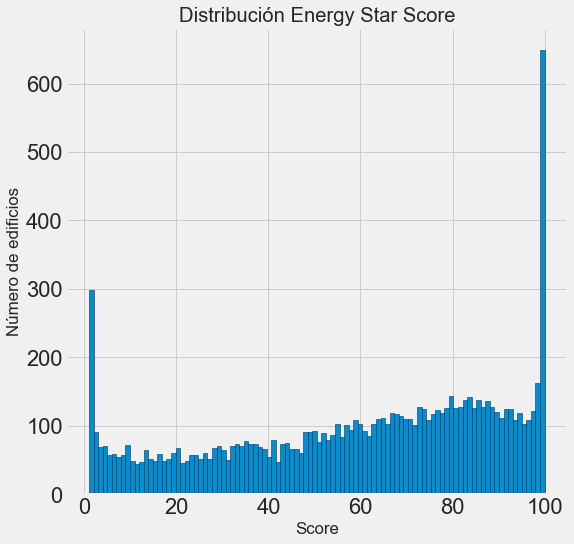

In [11]:
figsize(8, 8)

# Renombramos a score
data = data.rename(columns = {'ENERGY STAR Score': 'score'})

# Histograma de Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(data['score'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('Score'); plt.ylabel('Número de edificios'); 
plt.title('Distribución Energy Star Score');

¡Esto parece bastante sospechoso! La puntuación de Energy Star es un rango percentil, lo que significa que esperaríamos ver una distribución uniforme, con cada puntuación asignada al mismo número de edificios. Sin embargo, un número desproporcionado de edificios tiene la puntuación más alta, 100, o la más bajo, 1 (más alto es mejor para la puntuación Energy Star).

Si volvemos a la definición de la puntuación, vemos que se basa en el "consumo de energía autoinformado" que podría explicar las puntuaciones muy altas. Pedir a los propietarios de edificios que informen sobre su propio consumo de energía es como pedirles a los estudiantes que reporten sus propias puntuaciones en una prueba. Como resultado, esta no es probablemente la medida más objetiva de la eficiencia energética de un edificio.

Si tuviéramos una cantidad de tiempo ilimitada, podríamos investigar por qué tantos edificios tienen puntuaciones muy altas y muy bajas, lo que podríamos hacer al seleccionar estos edificios y ver qué tienen en común. Sin embargo, nuestro objetivo es solo predecir la puntuación y no diseñar un mejor método para puntuar edificios. Podemos hacer una nota en nuestro informe de que las puntuaciones tienen una distribución sospechosa, pero nuestro enfoque principal es predecir la puntuación.

Para contrastar la puntuación de Energy Star, podemos observar la intensidad de uso de energía (EUI, por sus siglas en inglés), que es el uso de energía total dividido por la superficie cuadrada del edificio. En este caso, el uso de energía no es autoinformado, por lo que podría ser una medida más objetiva de la eficiencia energética de un edificio. Además, este no es un rango de percentil, por lo que los valores absolutos son importantes y esperamos que se distribuyan aproximadamente normalmente con quizás algunos valores atípicos en el extremo alto o bajo.

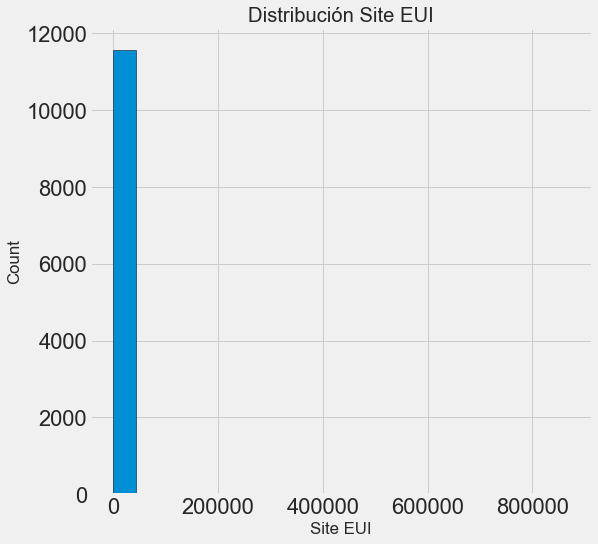

In [12]:
# Histograma de Site EUI
figsize(8, 8)
plt.hist(data['Site EUI (kBtu/ft²)'].dropna(), bins = 20, edgecolor = 'black');
plt.xlabel('Site EUI'); 
plt.ylabel('Count'); plt.title('Distribución Site EUI');

Bueno, esto nos muestra que tenemos otro problema: ¡los valores atípicos! El gráfico es increíblemente sesgado debido a la presencia de unos pocos edificios con puntuaciones muy altas. Parece que tendremos que tomar un pequeño desvío para lidiar con los valores atípicos. Veamos las estadísticas de esta característica.

In [13]:
data['Site EUI (kBtu/ft²)'].describe()

count     11583.000000
mean        280.071484
std        8607.178877
min           0.000000
25%          61.800000
50%          78.500000
75%          97.600000
max      869265.000000
Name: Site EUI (kBtu/ft²), dtype: float64

In [14]:
data['Site EUI (kBtu/ft²)'].dropna().sort_values().tail(10)

3173     51328.8
3170     51831.2
3383     78360.1
8269     84969.6
3263     95560.2
8268    103562.7
8174    112173.6
3898    126307.4
7       143974.4
8068    869265.0
Name: Site EUI (kBtu/ft²), dtype: float64

¡Un edificio está claramente muy por encima del resto!

In [16]:
data.loc[data['Site EUI (kBtu/ft²)'] == 869265, :]

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
8068,9984,4414323,234 Skillman,Not Applicable: Standalone Property,Not Applicable: Standalone Property,3028937502,3028937502,"3390250 , 3338313",234 Skillman avenue,11211,234,SKILLMAN AVENUE,Brooklyn,61811.0,Multifamily Housing,Multifamily Housing,Multifamily Housing,56900.0,2004,1,90,Whole Building,NaN,1.0,869265.0,939329.0,9.9,9393.0,986366.0,4.945919e+10,534458968.8,1983655.6,563239.6,2627199.1,2627015.0,184.1,56900.0,2547.9,44.78,912801.1,05/01/2017 11:34:14 PM,NaN,In Compliance,40.716233,-73.94141,1.0,34.0,477.0,East Williamsburg ...


¡Podría valer la pena que alguien haga un seguimiento con el propietario de este edificio! Sin embargo, ese no es nuestro problema y solo necesitamos averiguar cómo manejar esta información. Los valores atípicos pueden ocurrir por muchas razones: errores tipográficos, fallas en los dispositivos de medición, unidades incorrectas o pueden ser valores legítimos pero extremos. Los valores atípicos pueden descartar un modelo porque no son indicativos de la distribución real de los datos.

### Eliminando valores atípicos

Cuando eliminamos los valores atípicos, debemos tener cuidado de no desechar las medidas simplemente porque se ven extrañas. Pueden ser el resultado de un fenómeno real que deberíamos investigar más a fondo. Al eliminar los valores atípicos, trato de ser lo más conservador posible. Para este proyecto, eliminaremos anomalías basadas en la [definición de valores extremos](https://people.richland.edu/james/lecture/m170/ch03-pos.html):

+ Por debajo del primer cuartil - 3 * rango intercuartil
+ Por encima del tercer cuartil + 3 * range rango intercuartil

En este caso, solo eliminaré el único punto externo y veré cómo se ve la distribución.

In [17]:
# Calculamos el primer y tercer cuartil
first_quartile = data['Site EUI (kBtu/ft²)'].describe()['25%']
third_quartile = data['Site EUI (kBtu/ft²)'].describe()['75%']

# Rango intercuartil
iqr = third_quartile - first_quartile

# Eliminamos valores atípicos
data = data[(data['Site EUI (kBtu/ft²)'] > (first_quartile - 3 * iqr)) &
            (data['Site EUI (kBtu/ft²)'] < (third_quartile + 3 * iqr))]

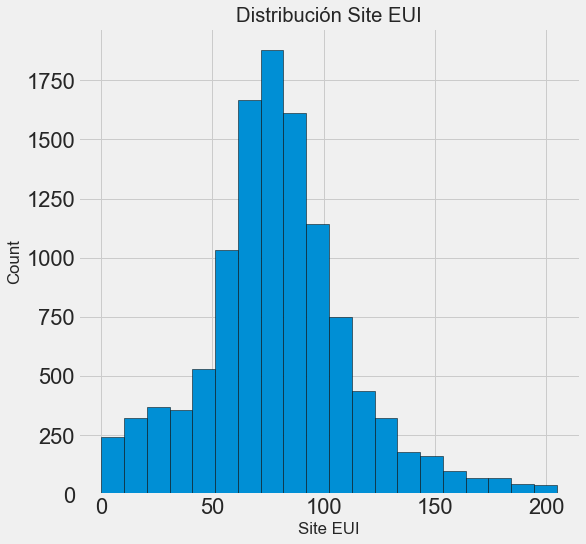

In [18]:
# Histograma de Site EUI
figsize(8, 8)
plt.hist(data['Site EUI (kBtu/ft²)'].dropna(), bins = 20, edgecolor = 'black');
plt.xlabel('Site EUI'); 
plt.ylabel('Count'); plt.title('Distribución Site EUI');

Después de eliminar los valores atípicos, podemos volver al análisis.

Este gráfico parece un poco menos sospechoso y está casi distribuido normalmente con una cola larga en el lado derecho (tiene un sesgo positivo).

Aunque esta podría ser una medida más objetiva, nuestro objetivo aún es predecir la puntuación Energy Star, por lo que volveremos a examinar esa variable. Incluso si la puntuación no es una buena medida, nuestra tarea es predecirlo, ¡así que eso es lo que trataremos de hacer! En el informe final a la compañía, señalaré que esto podría no ser una medida objetiva, y sería una buena idea usar diferentes métricas para determinar la eficiencia de un edificio. Además, si tuviéramos más tiempo para este proyecto, podría ser interesante echar un vistazo a los edificios con puntuaciones de 1 y 100 para ver si tienen algo en común.

### Buscando relaciones

Una parte importante de EDA es buscar relaciones entre las características y el objetivo. Las variables que están correlacionadas con el objetivo son útiles para un modelo porque pueden usarse para predecir el objetivo. Una forma de examinar el efecto de una variable categórica (que toma solo un conjunto limitado de valores) en el objetivo es a través de un gráfico de densidad utilizando la biblioteca `seaborn`. 

[Los gráficos de densidad se pueden considerar como un histograma suavizado](https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0). Si coloreamos las curvas de densidad con una variable categórica, esto nos mostrará cómo cambia la distribución en función de la clase.

El primer gráfico que haremos muestra la distribución de puntuaciones por tipo de propiedad. Para no desordenar la trama, limitaremos el gráfico a los tipos de construcción que tengan más de 100 observaciones en el conjunto de datos.

In [19]:
# Creamos una lista de edificios con más de 100 observaciones
types = data.dropna(subset=['score'])
types = types['Largest Property Use Type'].value_counts()
types = list(types[types.values > 100].index)

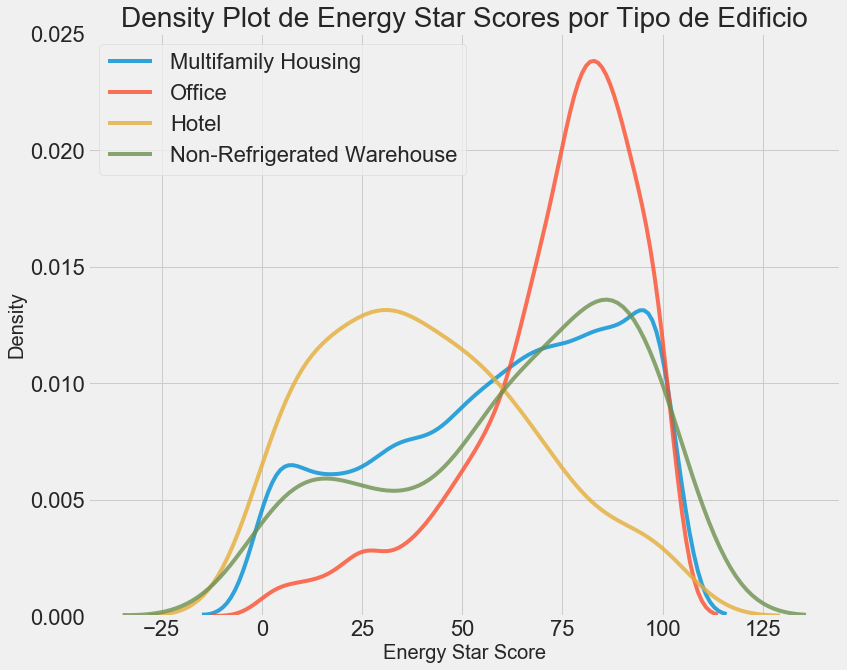

In [21]:
# Dibujamos la distribución de puntuaciones por categoría de edificio
figsize(12, 10)

# Dibujamos cada edificio
for b_type in types:
    # Seleccionamos el tipo de edificio
    subset = data[data['Largest Property Use Type'] == b_type]
    
    # Density plot de Energy Star scores
    sns.kdeplot(subset['score'].dropna(),
               label = b_type, shade = False, alpha = 0.8);
    
# Etuqietamos el plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot de Energy Star Scores por Tipo de Edificio', size = 28);

A partir de este gráfico, podemos ver que el tipo de construcción tiene un efecto en la puntuación (las puntuaciones negativas en la gráfica son un artefacto del procedimiento del [kernel density estimation](https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/). Aunque inicialmente iba a centrarme en las columnas numéricas para predecir la puntuación, este gráfico nos dice que debemos incluir el tipo de propiedad porque esta información puede ser útil para determinar la puntuación. Como el tipo de construcción es una variable categórica, tendrá que estar codificada antes de poder incorporarla a un modelo de machine learning.

Para examinar otra variable categórica, el municipio, podemos hacer el mismo gráfico, pero esta vez con el color del municipio.

In [22]:
# Creamos una lista de municipios con más de 100 observaciones
boroughs = data.dropna(subset=['score'])
boroughs = boroughs['Borough'].value_counts()
boroughs = list(boroughs[boroughs.values > 100].index)

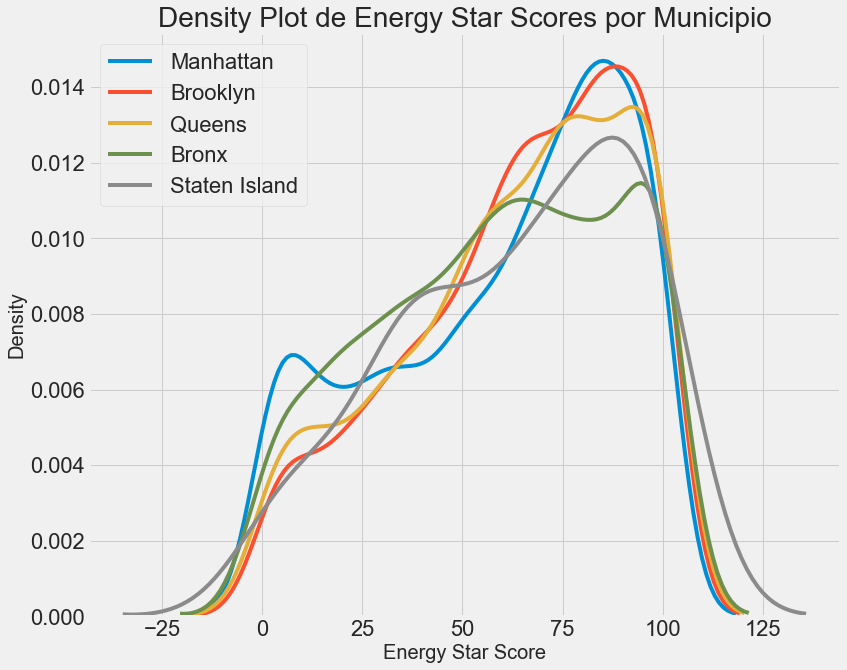

In [23]:
# Dibujamos la distribución de puntuaciones por municipio
figsize(12, 10)

# Dibujamos cada municipio
for borough in boroughs:
    # Seleccionamos el municipio
    subset = data[data['Borough'] == borough]
    
    # Density plot de Energy Star scores
    sns.kdeplot(subset['score'].dropna(),
               label = borough);
    
# label the plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot de Energy Star Scores por Municipio', size = 28);

El municipio no parece tener un impacto tan grande en la puntuación como el tipo de edificio. No obstante, podríamos incluirlo en nuestro modelo porque existen pequeñas diferencias entre los municipios.

### Correlaciones entre características y objetivo

Para cuantificar las relaciones entre variables, podemos utilizar el [coeficiente de correlación de Pearson](http://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/). Esta es una medida de la fuerza y la dirección de una relación lineal entre dos variables. Una puntuación de +1 es una relación positiva perfectamente lineal y una puntuación de -1 es una relación lineal perfectamente negativa. A continuación se muestran varios valores del coeficiente de correlación y cómo aparecen gráficamente.:

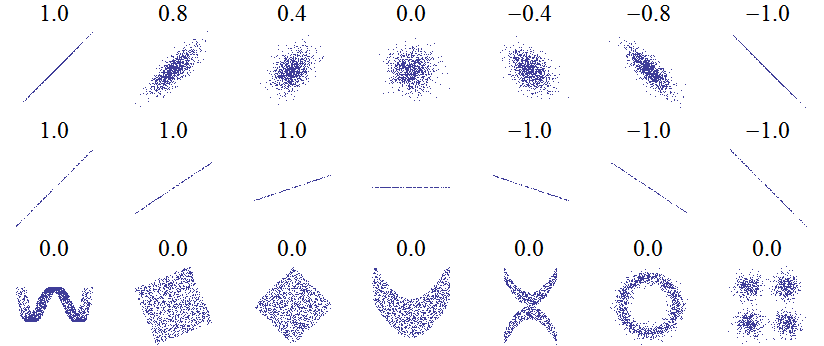

In [27]:
Image(filename="./images/correlation_examples.png")

Aunque puede haber relaciones no lineales entre las características y los objetivos y los coeficientes de correlación no tienen en cuenta las interacciones entre las características, las relaciones lineales son una buena manera de comenzar a explorar tendencias en los datos. Luego podemos usar estos valores para seleccionar las características que emplearemos en nuestro modelo.

El siguiente código calcula los coeficientes de correlación entre todas las variables y la puntuación.

In [28]:
# Encuentra todas las correlaciones y las ordena
correlations_data = data.corr()['score'].sort_values()

# Imprime la correlaciones más negativas
print(correlations_data.head(15), '\n')

# Imprime las correlaciones más positivas
print(correlations_data.tail(15))

Site EUI (kBtu/ft²)                                          -0.723864
Weather Normalized Site EUI (kBtu/ft²)                       -0.713993
Weather Normalized Source EUI (kBtu/ft²)                     -0.645542
Source EUI (kBtu/ft²)                                        -0.641037
Weather Normalized Site Electricity Intensity (kWh/ft²)      -0.358394
Weather Normalized Site Natural Gas Intensity (therms/ft²)   -0.346046
Direct GHG Emissions (Metric Tons CO2e)                      -0.147792
Weather Normalized Site Natural Gas Use (therms)             -0.135211
Natural Gas Use (kBtu)                                       -0.133648
Year Built                                                   -0.121249
Total GHG Emissions (Metric Tons CO2e)                       -0.113136
Electricity Use - Grid Purchase (kBtu)                       -0.050639
Weather Normalized Site Electricity (kWh)                    -0.048207
Latitude                                                     -0.048196
Proper

Hay varias correlaciones negativas fuertes entre las características y el objetivo. Las correlaciones más negativas con la puntuación son las diferentes categorías de Intensidad de uso de energía (EUI), `Site EUI (kBtu/ft²)` y `EWeather Normalized Site EUI (kBtu/ft²)` (varían ligeramente en la forma en que se calculan). La EUI es la cantidad de energía utilizada por un edificio dividida por la superficie cuadrada de los edificios y está destinada a ser una medida de la eficiencia de un edificio con una puntuación más baja mejor. Intuitivamente, estas correlaciones tienen sentido: a medida que aumenta la EUI, la puntuación Energy Star tiende a disminuir.

Para tener en cuenta las posibles relaciones no lineales, podemos tomar la raíz cuadrada y las transformaciones de registro natural de las características y luego calcular los coeficientes de correlación con la puntuación. Para intentar capturar cualquier posible relación entre la ciudad o el tipo de edificio (recuerde que estas son variables categóricas) y la puntuación que tendremos codificar estas columnas.

En el siguiente código, tomamos las transformaciones de logaritmo y raíz cuadrada de las variables numéricas, codificamos las dos variables categóricas seleccionadas (tipo de construcción y municipio), calculamos las correlaciones entre todas las características y la puntuación, y mostramos las 15 principales correlaciones positivas y las 15 más negativas. 

In [29]:
# Seleccionamos las columnas numéricas
numeric_subset = data.select_dtypes('number')

# Creamos columnas con la raiz cuadrada y el logaritmo de las columnas numéricas
for col in numeric_subset.columns:
    # Saltamos la columna Energy Star Score
    if col == 'score':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Seleccionamos las columnas categóricas
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# Las codificamos
categorical_subset = pd.get_dummies(categorical_subset)

# Unimos los dos dataframes usando concat
# Nos aseguramos usar axis = 1 para ejecutar una unión por columna
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Eliminamos los edificios sin energy star score
features = features.dropna(subset = ['score'])

# Encontramos las correlaciones con score 
correlations = features.corr()['score'].dropna().sort_values()

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [30]:
# Mostramos las principales correlaciones negativas
correlations.head(15)

Site EUI (kBtu/ft²)                                            -0.723864
Weather Normalized Site EUI (kBtu/ft²)                         -0.713993
sqrt_Site EUI (kBtu/ft²)                                       -0.699817
sqrt_Weather Normalized Site EUI (kBtu/ft²)                    -0.689019
sqrt_Weather Normalized Source EUI (kBtu/ft²)                  -0.671044
sqrt_Source EUI (kBtu/ft²)                                     -0.669396
Weather Normalized Source EUI (kBtu/ft²)                       -0.645542
Source EUI (kBtu/ft²)                                          -0.641037
log_Source EUI (kBtu/ft²)                                      -0.622892
log_Weather Normalized Source EUI (kBtu/ft²)                   -0.620329
log_Site EUI (kBtu/ft²)                                        -0.612039
log_Weather Normalized Site EUI (kBtu/ft²)                     -0.601332
log_Weather Normalized Site Electricity Intensity (kWh/ft²)    -0.424246
sqrt_Weather Normalized Site Electricity Intensity 

In [31]:
# Mostramos las principales correlaciones positivas
correlations.tail(15)

sqrt_Order                                                         0.028662
Borough_Queens                                                     0.029545
Largest Property Use Type_Supermarket/Grocery Store                0.030038
Largest Property Use Type_Residence Hall/Dormitory                 0.035407
Order                                                              0.036827
Largest Property Use Type_Hospital (General Medical & Surgical)    0.048410
Borough_Brooklyn                                                   0.050486
log_Community Board                                                0.055495
Community Board                                                    0.056612
sqrt_Community Board                                               0.058029
sqrt_Council District                                              0.060623
log_Council District                                               0.061101
Council District                                                   0.061639
Largest Prop

Después de transformar las características, las relaciones más fuertes siguen siendo las relacionadas con Energy Use Intensity (EUI). Las transformaciones de log y raíz cuadrada no parecen haber resultado en relaciones más sólidas. No hay relaciones lineales positivas fuertes, aunque sí vemos que un tipo de oficina de edificio (`Largest Property Use Type_Office`) está ligeramente correlacionado positivamente con la puntuación. Esta variable es una representación codificada de las variables categóricas para el tipo de construcción.

Podemos usar estas correlaciones para realizar la selección de características. En este momento, vamos a graficar la correlación más significativa (en términos de valor absoluto) en el conjunto de datos que es `Site EUI (kBtu/ft^2)`. Podemos colorear el gráfico por tipo de edificio para mostrar cómo afecta eso a la relación.

### Gráfico de dos variables

Para visualizar la relación entre dos variables, utilizamos un diagrama de dispersión (scatterplot). También podemos incluir variables adicionales utilizando aspectos como el color de los marcadores o el tamaño de los marcadores. Aquí trazaremos dos variables numéricas una contra otra y usaremos el color para representar una tercera variable categórica.

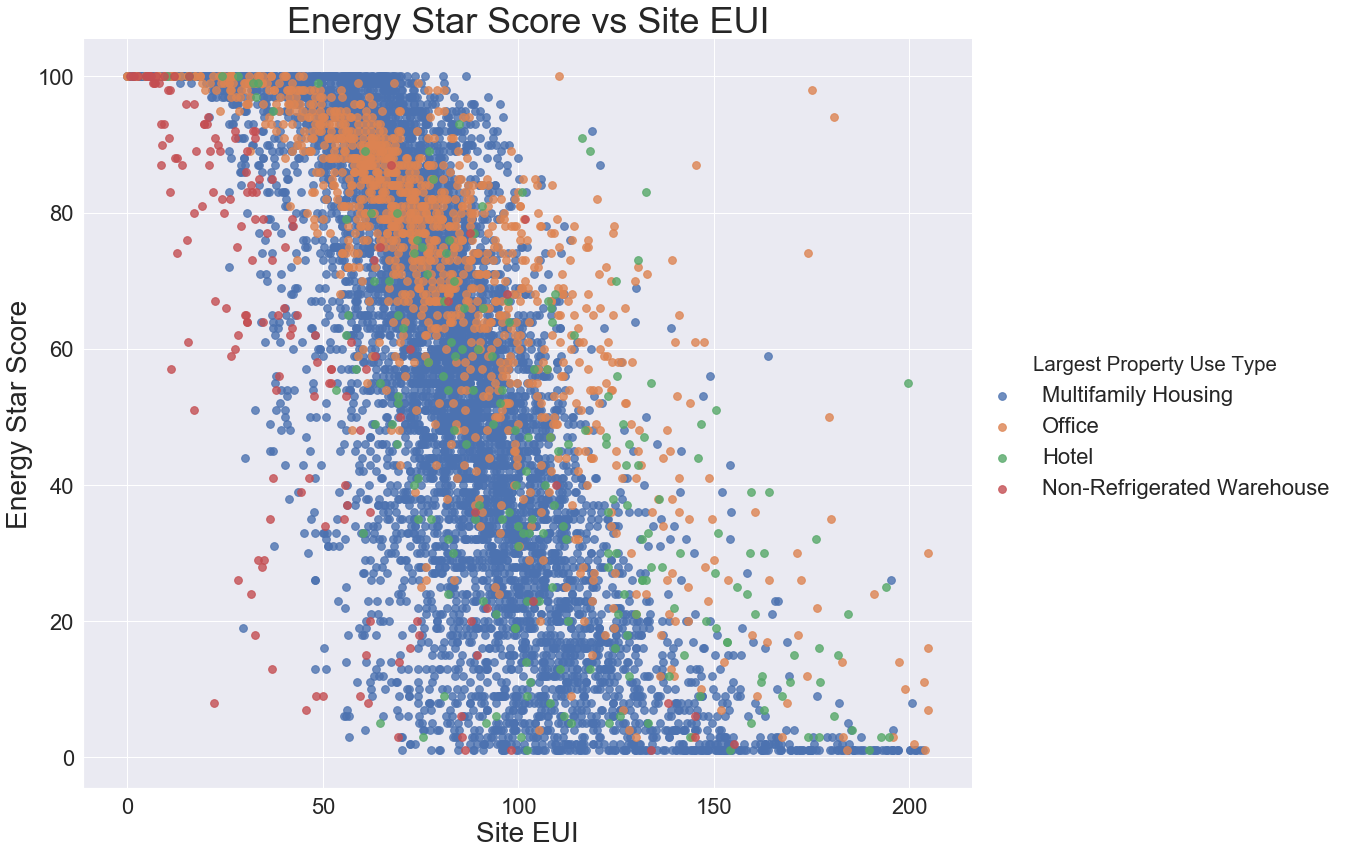

In [49]:
figsize(12, 10)

# Extraemos los tipos de edificio
features['Largest Property Use Type'] = data.dropna(subset = ['score'])['Largest Property Use Type']

# Limitamos a tipos de edificio con más de 100 observaciones
features = features[features['Largest Property Use Type'].isin(types)]

# Usamos seaborn para dibujar un scatterplot de Score vs Log Source EUI
sns.lmplot('Site EUI (kBtu/ft²)', 'score', 
          hue = 'Largest Property Use Type', data = features,
          scatter_kws = {'alpha': 0.8, 's': 60}, fit_reg = False,
          height = 12, aspect = 1.2);

# Etiquetamos el plot
plt.xlabel("Site EUI", size = 28)
plt.ylabel('Energy Star Score', size = 28)
plt.title('Energy Star Score vs Site EUI', size = 36);

Existe una clara relación negativa entre Site EUI y la puntuación. La relación no es perfectamente lineal (se ve con un coeficiente de correlación de -0.7, pero parece que esta característica será importante para predecir la puntuación de un edificio). Una relación que se mantiene estable en todos los tipos de edificios.

### Pairs Plots

El gráfico final de exploración que haremos se conoce como Pairs Plot. Esta es una gran herramienta de exploración porque nos permite ver las relaciones entre varios pares de variables, así como las distribuciones de variables individuales. Aquí estamos utilizando la biblioteca de visualización `seaborn` y la función `PairGrid` para crear un gráfico de pares con diagramas de dispersión en el triángulo superior, histogramas en la diagonal y gráficos de densidad de kernel 2D y coeficientes de correlación en el triángulo inferior.

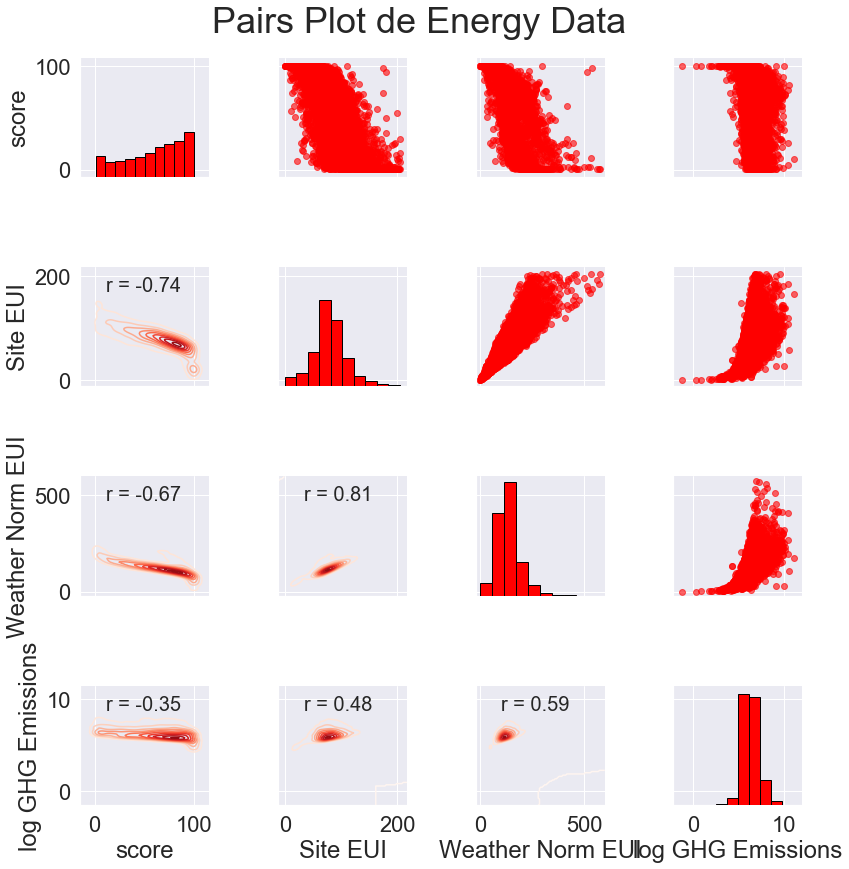

In [52]:
# Extraemos las columnas a dibujar
plot_data = features[['score', 'Site EUI (kBtu/ft²)', 
                      'Weather Normalized Source EUI (kBtu/ft²)', 
                      'log_Total GHG Emissions (Metric Tons CO2e)']]

# Reemplaza la información con nan
plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})

# Renombramos columnas
plot_data = plot_data.rename(columns = {'Site EUI (kBtu/ft²)': 'Site EUI', 
                                        'Weather Normalized Source EUI (kBtu/ft²)': 'Weather Norm EUI',
                                        'log_Total GHG Emissions (Metric Tons CO2e)': 'log GHG Emissions'})

# Eliminamos valores na
plot_data = plot_data.dropna()

# Función para calcular el coeficiente de correlación entre dos columnas
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Crea el objeto pairgrid
grid = sns.PairGrid(data = plot_data, height = 3)

# En la parte superior está el scatter plot
grid.map_upper(plt.scatter, color = 'red', alpha = 0.6)

# En la diagonal está el histograma
grid.map_diag(plt.hist, color = 'red', edgecolor = 'black')

# En la parte inferior está la correlación y el plot de densidad
grid.map_lower(corr_func);
grid.map_lower(sns.kdeplot, cmap = plt.cm.Reds)

# Título global para el gráfico
plt.suptitle('Pairs Plot de Energy Data', size = 36, y = 1.02);

Para ver las interacciones entre las variables, buscamos donde una fila intersecciona con una columna. Por ejemplo, para ver la correlación de `Weather Norm EUI` con `score`, buscamos en la fila `Weather Norm EUI` y en la columna `score` y vemos un coeficiente de correlación de -0.67. Si observamos la gráfica superior derecha, podemos ver un diagrama de dispersión de esta relación. Además de verse geniales, los gráficos como estos pueden ayudarnos a decidir qué variables incluir en el modelado.